# Table of Contents
 <p><div class="lev2 toc-item"><a href="#Globally-relevant-variables" data-toc-modified-id="Globally-relevant-variables-01"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Globally relevant variables</a></div><div class="lev2 toc-item"><a href="#Classes-to-encapsulate-single-lines-of-text-and-multiple-lines-of-text" data-toc-modified-id="Classes-to-encapsulate-single-lines-of-text-and-multiple-lines-of-text-02"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Classes to encapsulate single lines of text and multiple lines of text</a></div><div class="lev2 toc-item"><a href="#Parse-the-downloaded-subject-data-into-data-structures-for-processing" data-toc-modified-id="Parse-the-downloaded-subject-data-into-data-structures-for-processing-03"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Parse the downloaded subject data into data structures for processing</a></div><div class="lev2 toc-item"><a href="#Parse-the-downloaded-classification-data-into-data-structures-for-processing" data-toc-modified-id="Parse-the-downloaded-classification-data-into-data-structures-for-processing-04"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Parse the downloaded classification data into data structures for processing</a></div><div class="lev3 toc-item"><a href="#Print-some-summary-information-about-the-parsed-data" data-toc-modified-id="Print-some-summary-information-about-the-parsed-data-041"><span class="toc-item-num">0.4.1&nbsp;&nbsp;</span>Print some summary information about the parsed data</a></div><div class="lev2 toc-item"><a href="#Cast-parsed-data-into-structures-that-enable-&quot;straightfoward&quot;-aggregation-analysis" data-toc-modified-id="Cast-parsed-data-into-structures-that-enable-&quot;straightfoward&quot;-aggregation-analysis-05"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>Cast parsed data into structures that enable "straightfoward" aggregation analysis</a></div><div class="lev2 toc-item"><a href="#Group-transcriptions-of-individual-lines-according-to-spatial-proximity" data-toc-modified-id="Group-transcriptions-of-individual-lines-according-to-spatial-proximity-06"><span class="toc-item-num">0.6&nbsp;&nbsp;</span>Group transcriptions of individual lines according to spatial proximity</a></div><div class="lev2 toc-item"><a href="#Experimental:-Evaluate-first-pass-line-consensus" data-toc-modified-id="Experimental:-Evaluate-first-pass-line-consensus-07"><span class="toc-item-num">0.7&nbsp;&nbsp;</span>Experimental: Evaluate first pass line consensus</a></div><div class="lev2 toc-item"><a href="#Serialize-the-processed-data-at-this-stage" data-toc-modified-id="Serialize-the-processed-data-at-this-stage-08"><span class="toc-item-num">0.8&nbsp;&nbsp;</span>Serialize the processed data at this stage</a></div><div class="lev2 toc-item"><a href="#Now-aggregate-the-text-of-the-spatially-matched-lines" data-toc-modified-id="Now-aggregate-the-text-of-the-spatially-matched-lines-09"><span class="toc-item-num">0.9&nbsp;&nbsp;</span>Now aggregate the text of the spatially matched lines</a></div><div class="lev2 toc-item"><a href="#Save-the-&quot;most-popular&quot;-transcriptions" data-toc-modified-id="Save-the-&quot;most-popular&quot;-transcriptions-010"><span class="toc-item-num">0.10&nbsp;&nbsp;</span>Save the "most popular" transcriptions</a></div><div class="lev2 toc-item"><a href="#Plot-reliability-distributions" data-toc-modified-id="Plot-reliability-distributions-011"><span class="toc-item-num">0.11&nbsp;&nbsp;</span>Plot reliability distributions</a></div><div class="lev2 toc-item"><a href="#Store-consensus-data-in-MySQL-database" data-toc-modified-id="Store-consensus-data-in-MySQL-database-012"><span class="toc-item-num">0.12&nbsp;&nbsp;</span>Store consensus data in MySQL database</a></div>

In [1]:
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as mplplot
import dateutil.parser
import pickle
import sys
import re as regex
import copy
import itertools
import functools
import gc
import os
import glob
from collections import Counter, OrderedDict

In [2]:
verbose = True
extraVerbose = False
if verbose:
    import pprint
    from IPython.core.display import display
    pprinter = pprint.PrettyPrinter(indent=4)

In [3]:
%matplotlib inline
#%matplotlib notebook

## Globally relevant variables

In [4]:
saveIdentifiedLineDetails = True
applyDoubleLineFix = False
applyDoubleWordFilter = True
applyDoubleLineFilter = True
classificationBaseDirectory = '/Users/hughdickinson/Google Drive/classifications'
consensusBaseDirectory = '/Users/hughdickinson/Google Drive/consensus'
databaseNamePattern = 'dcwConsensus_{mss_label}'  # 'dcwConsensusDoubleLineFix' if applyDoubleLineFix else 'dcwConsensus'
#sampleDataFileNamePattern = 'classification_export_{mss_label}.csv'#'decoding-the-civil-war-classifications-2.csv'
subjectDataFileName = 'decoding-the-civil-war-subjects-7-24-17.csv'
aggregatedDataFileNamePattern = 'decoding-the-civil-war-aggregated_{mss_label}.txt'  #'decoding-the-civil-war-aggregated.txt'
aggregatedDataCsvFileNamePattern = 'decoding-the-civil-war-consensus-linewise_{mss_label}.csv'  #'decoding-the-civil-war-consensus-linewise.csv'
aggregatedDataSubjectWiseCsvFileNamePattern = 'decoding-the-civil-war-consensus-subjectwise_{mss_label}_withBreaks.csv'  #'decoding-the-civil-war-consensus-subjectwise.csv'
identifiedLineFilePathPattern = 'dataWithLineIDs_subset_{mss_label}.pkl'  #'dataWithLineIDs_subset.pkl'
liveDate = dateutil.parser.parse("2016-06-20T00:00:00.00Z")

In [5]:
classificationCsvFiles = glob.glob(
    '{}/*.csv'.format(classificationBaseDirectory))

consensusCsvFiles = glob.glob('{}/*.csv'.format(consensusBaseDirectory))

consensusMssLabels = set([
    consensusCsvFile.split('/')[-1][len(
        'decoding-the-civil-war-consensus-subjectwise_'):
                                    -len('_withBreaks_clean.csv')]
    for consensusCsvFile in consensusCsvFiles
    if 'withBreaks' in consensusCsvFile
])
classificationMssLabels = set([
    classificationCsvFile.split('/')[-1][len('classification_export_'):-4]
    for classificationCsvFile in classificationCsvFiles
])

remainingMssLabels = classificationMssLabels - consensusMssLabels

# print(*enumerate(classificationCsvFiles), sep='\n')
# print(*enumerate(consensusCsvFiles), sep='\n')

# print(*enumerate(consensusMssLabels), sep='\n')
# print(*enumerate(classificationMssLabels), sep='\n')

remainingClassificationCsvFiles = list(
    sorted([
        '{base_dir}/classification_export_{label}.csv'.format(
            base_dir=classificationBaseDirectory, label=mssLabel)
        for mssLabel in remainingMssLabels
    ]))

print(*enumerate(remainingClassificationCsvFiles), sep='\n')

ledgerIndex = 30
mssLabel = remainingClassificationCsvFiles[ledgerIndex].split('/')[-1][len(
    'classification_export_'):-4]

databaseName = databaseNamePattern.format(
    mss_label=mssLabel
)  # 'dcwConsensusDoubleLineFix' if applyDoubleLineFix else 'dcwConsensus'
sampleDataFileName = classificationCsvFiles[
    ledgerIndex]  #'decoding-the-civil-war-classifications-2.csv'
aggregatedDataFileName = aggregatedDataFileNamePattern.format(
    mss_label=mssLabel)  #'decoding-the-civil-war-aggregated.txt'
aggregatedDataCsvFileName = aggregatedDataCsvFileNamePattern.format(
    mss_label=mssLabel)  #'decoding-the-civil-war-consensus-linewise.csv'
aggregatedDataSubjectWiseCsvFileName = aggregatedDataSubjectWiseCsvFileNamePattern.format(
    mss_label=mssLabel)  #'decoding-the-civil-war-consensus-subjectwise.csv'
identifiedLineFilePath = identifiedLineFilePathPattern.format(
    mss_label=mssLabel)  #'dataWithLineIDs_subset.pkl'

(0, '/Users/hughdickinson/Google Drive/classifications/classification_export_mssEC_37_07_16_17.csv')
(1, '/Users/hughdickinson/Google Drive/classifications/classification_export_mssEC_38_07_16_17.csv')
(2, '/Users/hughdickinson/Google Drive/classifications/classification_export_mssEC_39_07_16_17.csv')
(3, '/Users/hughdickinson/Google Drive/classifications/classification_export_mssEC_40_05_30_17.csv')
(4, '/Users/hughdickinson/Google Drive/classifications/classification_export_mssEC_41_05_30_17.csv')
(5, '/Users/hughdickinson/Google Drive/classifications/classification_export_mssEC_42_05_30_17.csv')
(6, '/Users/hughdickinson/Google Drive/classifications/classification_export_mssEC_43_05_30_17.csv')
(7, '/Users/hughdickinson/Google Drive/classifications/classification_export_mssEC_44_05_30_17.csv')
(8, '/Users/hughdickinson/Google Drive/classifications/classification_export_mssEC_45_05_30_17.csv')
(9, '/Users/hughdickinson/Google Drive/classifications/classification_export_mssEC_46_05_30

## Classes to encapsulate single lines of text and multiple lines of text

In [6]:
class TextLine():
    def __init__(self, x1, y1, x2, y2, text):
        self.coords = {'start': {'x': x1, 'y': y1}, 'end': {'x': x2, 'y': y2}}
        self.text = text
        self.words = text.split()
        self.numWords = len(self.words)

    def __str__(self):
        return str(
            self.text) + " @ ((" + str(self.coords['start']['x']) + ", " + str(
                self.coords['start']['y']) + "), (" + str(
                    self.coords['end']['x']) + ", " + str(
                        self.coords['end']['y']) + "))"

    def getStart(self):
        return self.coords['start']

    def getEnd(self):
        return self.coords['end']

    def getText(self):
        return str(self.text)

    def getCoords(self):
        return self.coords

    def getWords(self):
        return self.words

In [7]:
class TelegramLines():
    def __init__(self):
        self.textLines = []

    def __str__(self):
        return "\n".join([textLine.__str__() for textLine in self.textLines])

    def addLine(self, textLine):
        self.textLines.append(textLine)

    def getLines(self):
        return self.textLines

    def getNumLines(self):
        return len(self.textLines)

In [8]:
class LineMatcher():
    def __init__(self, _yTolerance, _xTolerance=None):
        self.currentCoords = (-1, -1, -1, -1)
        self.yTolerance = _yTolerance
        self.xTolerance = _xTolerance

    def compare(self, lineCoords):
        different = np.abs(
            lineCoords[1] - self.currentCoords[1]) > self.yTolerance or np.abs(
                lineCoords[3] - self.currentCoords[3]) > self.yTolerance
        if not different and self.xTolerance is not None:
            different = different and (
                np.abs(lineCoords[0] - self.currentCoords[0]) > self.xTolerance
                or np.abs(lineCoords[2] - self.currentCoords[2]) >
                self.xTolerance)
        if different:
            self.setCurrentCoords(lineCoords)
            return True
        else:
            return False

    def setCurrentCoords(self, _newCoords):
        self.currentCoords = _newCoords

In [9]:
class MetaTagState():
    def __init__(self):
        self.setTags = {}

    def setTag(self, tag, start, end):
        if tag in self.setTags:
            self.setTags[tag].append((start, end))
        else:
            self.setTags.update({tag: [(start, end)]})
        return self.setTags[tag]

    def reset(self):
        self.setTags = {}

    def getSetTags(self):
        return self.setTags

In [10]:
class StatefulWord():
    def __init__(self, _word, _span, _tagStates, _sentence):
        self.word = _word
        self.tagStates = _tagStates
        self.sentence = _sentence
        self.span = _span

    def __hash__(self):
        return self.word.__hash__()

    def __eq__(self, other):
        return self.word == other.word

    def __str__(self):
        return 'SW:' + str(self.word) + ' ' + str(self.tagStates)

    def __repr__(self):
        return 'SW:' + str(self.word)

    def asTuple(self):
        return (self.word, self.span, self.tagStates, self.sentence)

## Parse the downloaded subject data into data structures for processing

In [11]:
subject_data = []
subjectColumns = ['subject_id', 'huntington_id', 'url']
with open(subjectDataFileName) as csvfile:
    parsedSubjectCsv = csv.DictReader(csvfile)
    numPrinted = 0
    for subject in parsedSubjectCsv:
        parsedLocations = json.loads(subject['locations'])
        parsedMetaData = json.loads(subject['metadata'])
        if 'hdl_id' not in parsedMetaData:
            continue
        subject_data.append({
            'subject_id': int(subject['subject_id']),
            'huntington_id': parsedMetaData['hdl_id'],
            'url': parsedLocations['0']
        })
subjectsFrame = pd.DataFrame.from_records(subject_data, index='subject_id')
display(subjectsFrame)

,huntington_id,url
subject_id,,
1959268,mssEC_01_001,https://panoptes-uploads.zooniverse.org/produc...
1959268,mssEC_01_001,https://panoptes-uploads.zooniverse.org/produc...
1959268,mssEC_01_001,https://panoptes-uploads.zooniverse.org/produc...
1959268,mssEC_01_001,https://panoptes-uploads.zooniverse.org/produc...
1959269,mssEC_01_002,https://panoptes-uploads.zooniverse.org/produc...
1959269,mssEC_01_002,https://panoptes-uploads.zooniverse.org/produc...
1959269,mssEC_01_002,https://panoptes-uploads.zooniverse.org/produc...
1959269,mssEC_01_002,https://panoptes-uploads.zooniverse.org/produc...
1959270,mssEC_01_003,https://panoptes-uploads.zooniverse.org/produc...


## Parse the downloaded classification data into data structures for processing

In [12]:
telegrams = {}

with open(sampleDataFileName) as csvfile:
    parsedCsv = csv.DictReader(csvfile)
    nTelegramsParsed = 0
    for recordIndex, record in enumerate(parsedCsv):
        done = False
        recordIsTelegram = True

        # check the date that the classification was made
        if "metadata" in record:
            parsedMetadata = json.loads(record["metadata"])
            parsedDate = dateutil.parser.parse(parsedMetadata['started_at'])
            # skip "testing" data before the site went live
            if parsedDate < liveDate:
                continue

        # parse the annotations and the subject data
        parsedAnnotations = json.loads(record["annotations"])
        parsedSubjectData = json.loads(record["subject_data"])

        # initialize container for transcribed lines
        transcribedLines = TelegramLines()

        #loop over tasks in the annotation
        for task in parsedAnnotations:
            # Check if the current record is for a telegram (tasks may be stored out of order, so
            # some tasks may be processed before non-telegrams are caught - inefficient but unavoidable?)
            if task['task'] == "T1" and (
                    task['value'] is None
                    or not task['value'].startswith("Telegram")):
                recordIsTelegram = False
                break

            # Process transcriptions of text lines
            if task['task'].startswith("T12") and len(task['value']) > 0:
                # process the lines that were transcribed for this task
                for taskValueItem in task['value']:
                    transcribedLine = TextLine(
                        taskValueItem['x1'], taskValueItem['y1'],
                        taskValueItem['x2'], taskValueItem['y2'],
                        taskValueItem['details'][0]['value'])
                    transcribedLines.addLine(transcribedLine)

        # if the transcribed lines of a telegram have been processed then update the
        # list of independent transcriptions for this subject
        if recordIsTelegram:
            nTelegramsParsed += 1
            if int(record['subject_ids']) in telegrams:
                telegrams[int(record['subject_ids'])].append(
                    (recordIndex, transcribedLines))
            else:
                telegrams.update({
                    int(record['subject_ids']): [(recordIndex,
                                                  transcribedLines)]
                })

### Print some summary information about the parsed data

In [13]:
print(len(telegrams), nTelegramsParsed)

14 29


## Cast parsed data into structures that enable "straightfoward" aggregation analysis

In [14]:
transcriptionLineStats = {}
transcriptionLineDetails = []
# loop over distinct subjects (currently individual telegram-type pages, codebook handling to be implemented)
for key, transcriptions in telegrams.items():
    totalLines = 0
    maxLines = 0
    minLines = sys.maxsize
    # loop over individual transcriptions of the subject
    for transcriptionData in transcriptions:
        transcription = transcriptionData[1]
        transcriptionIndex = transcriptionData[0]
        # process overall transcription statistics for this subject
        numLines = transcription.getNumLines()
        totalLines += numLines
        maxLines = numLines if numLines > maxLines else maxLines
        minLines = numLines if numLines < minLines else minLines
        # process the lines of the individual transcriptions of a subject
        for textLine in transcription.getLines():
            # Add a dictionary describing the current line
            lineDescription = {
                'subjectKey': key,
                'transcriptionIndex': transcriptionIndex,
                'numLines': numLines,
                'x1': textLine.getStart()['x'],
                'y1': textLine.getStart()['y'],
                'x2': textLine.getEnd()['x'],
                'y2': textLine.getEnd()['y'],
                'words': textLine.getWords()
            }
            transcriptionLineDetails.append(lineDescription)
    transcriptionLineStats.update({
        key: {
            'minLines': minLines,
            'maxLines': maxLines,
            'meanLines': totalLines / float(len(transcriptions))
        }
    })

transcriptionLineDetailsFrame = pd.DataFrame(data=transcriptionLineDetails)
transcriptionLineDetailsIndex = pd.MultiIndex.from_arrays([
    transcriptionLineDetailsFrame['subjectKey'],
    transcriptionLineDetailsFrame['y1'], transcriptionLineDetailsFrame['y2'],
    transcriptionLineDetailsFrame['x1'], transcriptionLineDetailsFrame['x2']
])
transcriptionLineDetailsFrame = transcriptionLineDetailsFrame.set_index(
    transcriptionLineDetailsIndex)
transcriptionLineDetailsFrame = transcriptionLineDetailsFrame.sort_index(
    level=0, sort_remaining=True)
display(transcriptionLineDetailsFrame)

numLines  \
subjectKey y1          y2          x1         x2                      
1963832    544.938875  544.938875  591.296686 623.611123          2   
           591.941689  580.190986  573.670630 852.749855          2   
1963843    320.745055  322.536927  353.044415 987.367074         23   
           392.419928  392.419928  349.460671 921.067813         23   
           460.511057  456.927314  546.566582 978.407715         23   
           763.337395  766.921138  353.044415 1125.341212        23   
           817.093549  826.052908  349.460671 1132.508700        23   
           870.849704  879.809063  351.252543 1123.549340        23   
           928.189602  935.357089  349.460671 1123.549340        23   
           983.737628  994.488859  349.460671 1119.965596        23   
           1037.493783 1046.453142 351.252543 1111.006237        23   
           1094.833681 1100.209297 351.252543 1119.965596        23   
           1145.006092 1155.757323 351.252543 1123.549340        23   
           1204.137862 1213.097221 351.252543 1127.133084        23   
           1257.894017 1266.853376 351.252543 1125.341212        23   
           1317.025787 1320.609530 351.252543 1116.381852        23   
           1368.990069 1374.365685 354.836287 1119.965596        23   
           1424.538096 1429.913711 353.044415 1121.757468        23   
           1481.877994 1489.045481 349.460671 1127.133084        23   
           1535.634148 1542.801636 349.460671 1118.173724        23   
           1589.390303 1594.765918 354.836287 1121.757468        23   
           1646.730201 1653.897688 351.252543 1121.757468        23   
           1700.486356 1705.861971 351.252543 1119.965596        23   
           1756.034382 1761.409997 351.252543 1119.965596        23   
           1809.790537 1813.374280 351.252543 1118.173724        23   
1963847    172.329139  173.433813  247.891163 299.810840         25   
           318.146103  321.460125  356.149212 1113.955557        25   
           387.740563  388.845237  352.835190 1094.071425        25   
           450.706979  455.125675  353.939864 1090.757403        25   
           529.138831  529.138831  348.416494 1092.966751        25   
...                                                             ...   
1963888    1543.233410 1543.233410 149.573672 1433.208059        31   
           1598.467247 1589.629833 145.154965 1427.684675        31   
           1631.607549 1628.293519 144.050288 1427.684675        31   
           1674.689942 1659.224468 139.631581 1433.208059        31   
           1713.353628 1693.469447 150.678349 1426.579998        31   
           1747.598607 1737.656516 148.468995 1427.684675        31   
           1797.309060 1791.785677 155.097056 1421.056614        31   
1963889    165.595148  166.919909  551.906812 835.405709         21   
           290.122699  260.977953  203.494618 1405.053023        21   
           339.138862  339.138862  210.118424 1415.651113        21   
           409.351205  408.026444  183.623200 1438.172053        21   
           474.264503  472.939742  182.298438 1418.300635        21   
           527.254950  521.955905  206.144140 1401.078740        21   
           573.621592  581.570159  199.520334 1410.352068        21   
           639.859651  643.833934  215.417468 1398.429217        21   
           703.448187  704.772949  199.520334 1418.300635        21   
           773.660530  777.634813  210.118424 1360.011142        21   
           839.898589  834.599544  194.221289 1394.454934        21   
           907.461409  918.059499  198.195573 1434.197770        21   
           965.750901  973.699468  208.793662 1452.744426        21   
           1013.442304 1035.963244 228.665080 1427.573964        21   
           1047.226018 1078.156745 273.300897 1364.713679         2   
           1067.757512 1096.902258 229.989842 1407.702546        21   
           1131.346049 1165.789840 231.314603 1430.223486        21   
           1

## Group transcriptions of individual lines according to spatial proximity
**Note** that a very important parameter for this process is the pixel tolerance that specifies the allowed disparity between corresponding *y* coordinates of separately marked annotated lines

In [15]:
if saveIdentifiedLineDetails:
    transcriptionLineDetailsFrame['bestLineIndex'] = pd.Series(
        np.zeros_like(transcriptionLineDetailsFrame['subjectKey']),
        index=transcriptionLineDetailsFrame.index)
    # iterate over rows in sorted, grouped dataset and insert the best line index
    bestLineIndex = -1
    currentSubject = -1
    numSubjectsProcessed = 0
    # line matcher with 40 pixel tolerance for y coordinates of lines that are considered to be the same
    lineMatcher = LineMatcher(40)
    for index, row in transcriptionLineDetailsFrame.iterrows():
        # if this is a new subject, reset the line index
        if currentSubject != index[0]:
            bestLineIndex = -1
            currentSubject = index[0]
            numSubjectsProcessed += 1
            if numSubjectsProcessed % 100 == 0:
                print('Processed {0} subjects...'.format(numSubjectsProcessed))

        # if the line coordinates do not match within tolerance, then increment the line index
        if lineMatcher.compare((index[3], index[1], index[4], index[2])):
            bestLineIndex += 1

        # update the dataframe with the best line index
        transcriptionLineDetailsFrame.ix[index,
                                         'bestLineIndex'] = bestLineIndex
else:
    identifiedLineFile = open(identifiedLineFilePath, 'rb')
    transcriptionLineDetailsFrame = pickle.load(identifiedLineFile)
    identifiedLineFile.close()
display(transcriptionLineDetailsFrame)
pprinter.pprint(transcriptionLineStats)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


numLines  \
subjectKey y1          y2          x1         x2                      
1963832    544.938875  544.938875  591.296686 623.611123          2   
           591.941689  580.190986  573.670630 852.749855          2   
1963843    320.745055  322.536927  353.044415 987.367074         23   
           392.419928  392.419928  349.460671 921.067813         23   
           460.511057  456.927314  546.566582 978.407715         23   
           763.337395  766.921138  353.044415 1125.341212        23   
           817.093549  826.052908  349.460671 1132.508700        23   
           870.849704  879.809063  351.252543 1123.549340        23   
           928.189602  935.357089  349.460671 1123.549340        23   
           983.737628  994.488859  349.460671 1119.965596        23   
           1037.493783 1046.453142 351.252543 1111.006237        23   
           1094.833681 1100.209297 351.252543 1119.965596        23   
           1145.006092 1155.757323 351.252543 1123.549340        23   
           1204.137862 1213.097221 351.252543 1127.133084        23   
           1257.894017 1266.853376 351.252543 1125.341212        23   
           1317.025787 1320.609530 351.252543 1116.381852        23   
           1368.990069 1374.365685 354.836287 1119.965596        23   
           1424.538096 1429.913711 353.044415 1121.757468        23   
           1481.877994 1489.045481 349.460671 1127.133084        23   
           1535.634148 1542.801636 349.460671 1118.173724        23   
           1589.390303 1594.765918 354.836287 1121.757468        23   
           1646.730201 1653.897688 351.252543 1121.757468        23   
           1700.486356 1705.861971 351.252543 1119.965596        23   
           1756.034382 1761.409997 351.252543 1119.965596        23   
           1809.790537 1813.374280 351.252543 1118.173724        23   
1963847    172.329139  173.433813  247.891163 299.810840         25   
           318.146103  321.460125  356.149212 1113.955557        25   
           387.740563  388.845237  352.835190 1094.071425        25   
           450.706979  455.125675  353.939864 1090.757403        25   
           529.138831  529.138831  348.416494 1092.966751        25   
...                                                             ...   
1963888    1543.233410 1543.233410 149.573672 1433.208059        31   
           1598.467247 1589.629833 145.154965 1427.684675        31   
           1631.607549 1628.293519 144.050288 1427.684675        31   
           1674.689942 1659.224468 139.631581 1433.208059        31   
           1713.353628 1693.469447 150.678349 1426.579998        31   
           1747.598607 1737.656516 148.468995 1427.684675        31   
           1797.309060 1791.785677 155.097056 1421.056614        31   
1963889    165.595148  166.919909  551.906812 835.405709         21   
           290.122699  260.977953  203.494618 1405.053023        21   
           339.138862  339.138862  210.118424 1415.651113        21   
           409.351205  408.026444  183.623200 1438.172053        21   
           474.264503  472.939742  182.298438 1418.300635        21   
           527.254950  521.955905  206.144140 1401.078740        21   
           573.621592  581.570159  199.520334 1410.352068        21   
           639.859651  643.833934  215.417468 1398.429217        21   
           703.448187  704.772949  199.520334 1418.300635        21   
           773.660530  777.634813  210.118424 1360.011142        21   
           839.898589  834.599544  194.221289 1394.454934        21   
           907.461409  918.059499  198.195573 1434.197770        21   
           965.750901  973.699468  208.793662 1452.744426        21   
           1013.442304 1035.963244 228.665080 1427.573964        21   
           1047.226018 1078.156745 273.300897 1364.713679         2   
           1067.757512 1096.902258 229.989842 1407.702546        21   
           1131.346049 1165.789840 231.314603 1430.223486        21   
           1

{   1963832: {'maxLines': 2, 'meanLines': 2.0, 'minLines': 2},
    1963843: {'maxLines': 23, 'meanLines': 23.0, 'minLines': 23},
    1963846: {'maxLines': 0, 'meanLines': 0.0, 'minLines': 0},
    1963847: {'maxLines': 25, 'meanLines': 25.0, 'minLines': 25},
    1963849: {'maxLines': 0, 'meanLines': 0.0, 'minLines': 0},
    1963850: {'maxLines': 31, 'meanLines': 31.0, 'minLines': 31},
    1963859: {'maxLines': 0, 'meanLines': 0.0, 'minLines': 0},
    1963875: {'maxLines': 0, 'meanLines': 0.0, 'minLines': 0},
    1963884: {'maxLines': 25, 'meanLines': 16.666666666666668, 'minLines': 0},
    1963885: {'maxLines': 27, 'meanLines': 12.0, 'minLines': 0},
    1963886: {'maxLines': 24, 'meanLines': 18.0, 'minLines': 0},
    1963887: {'maxLines': 28, 'meanLines': 10.166666666666666, 'minLines': 0},
    1963888: {'maxLines': 31, 'meanLines': 31.0, 'minLines': 31},
    1963889: {'maxLines': 21, 'meanLines': 11.5, 'minLines': 2}}


## Experimental: Evaluate first pass line consensus
Combine adjacent line groups that have very close mean Y values.

In [16]:
if applyDoubleLineFix:
    transcriptionLineDetailsFirstPass = transcriptionLineDetailsFrame.set_index(
        'bestLineIndex', drop=False, append=True)
    transcriptionLineDetailsFirstPass[
        'oldBestLineIndex'] = transcriptionLineDetailsFirstPass[
            'bestLineIndex'].astype(np.int64)
    transcriptionLineDetailsFirstPass = transcriptionLineDetailsFirstPass.groupby(
        level=[0, 5]).aggregate({
            'y1': np.mean,
            'y2': np.mean,
            'bestLineIndex': 'first',
            'oldBestLineIndex': 'first'
        })
    transcriptionLineDetailsFirstPass['meanY'] = 0.5 * (
        transcriptionLineDetailsFirstPass['y1'] +
        transcriptionLineDetailsFirstPass['y2'])
    transcriptionLineDetailsFirstPass.set_index(
        'meanY', drop=False, append=True)

    oldColumnNames = transcriptionLineDetailsFirstPass.columns
    newColumnNames = [(name if name != 'bestLineIndex' else 'newBestLineIndex')
                      for name in oldColumnNames]
    transcriptionLineDetailsFirstPass.columns = newColumnNames

    thisRow = transcriptionLineDetailsFirstPass.iloc[0]
    #display(thisRow)

    meanYThreshold = 20
    bestLineIndexDecrement = 0

    for index, nextRow in transcriptionLineDetailsFirstPass.iterrows():
        if nextRow['newBestLineIndex'] == 0:  # new subject
            bestLineIndexDecrement = 0  # so reset the decrement
        elif np.abs(thisRow['meanY'] - nextRow['meanY']) < meanYThreshold:
            bestLineIndexDecrement += 1

        transcriptionLineDetailsFirstPass.loc[
            index, 'newBestLineIndex'] -= int(bestLineIndexDecrement)

        thisRow = nextRow

    transcriptionLineDetailsFirstPass.reset_index(
        level='bestLineIndex', drop=True, inplace=True)
    transcriptionLineDetailsFirstPass.columns = oldColumnNames

In [17]:
if applyDoubleLineFix:
    transcriptionLineDetailsSecondPass = transcriptionLineDetailsFirstPass.set_index(
        'bestLineIndex', drop=False, append=True)
    transcriptionLineDetailsMismatches = transcriptionLineDetailsSecondPass[(
        transcriptionLineDetailsSecondPass['bestLineIndex'] !=
        transcriptionLineDetailsSecondPass['oldBestLineIndex'])]
    transcriptionLineDetailsMismatches.reset_index(
        level='bestLineIndex', drop=True, inplace=True)
    display(transcriptionLineDetailsMismatches)
    for mismatchIndex, mismatchRow in transcriptionLineDetailsMismatches.iterrows(
    ):
        for index, row in transcriptionLineDetailsFrame.loc[
                mismatchIndex].iterrows():
            if row['bestLineIndex'] == mismatchRow['oldBestLineIndex']:
                transcriptionLineDetailsFrame.loc[
                    mismatchIndex, 'bestLineIndex'] = mismatchRow[
                        'bestLineIndex']

    #display(transcriptionLineDetailsFrame.ix[2341364,:])

## Serialize the processed data at this stage
The previous step is time consuming so save the data.

In [18]:
if saveIdentifiedLineDetails:
    transcriptionLineDetailsFrame.to_pickle(identifiedLineFilePath)

## Now aggregate the text of the spatially matched lines
In the process, identify, strip and note any metatags e.g. `[unclear][/unclear]` that surround individual words.

In [19]:
def computeConsensusWordReliability(wordOptions):
    uniqueWordOptions = list(set(wordOptions))
    #simple logic to return 0 reliability for words with very few consistent transcriptions
    if len(wordOptions) < 2:
        return -0.25

    if (len(wordOptions) < 3 and len(uniqueWordOptions) > 1):
        return -0.5

    # more complicated logic that computes the fraction of transcribed words that equal the
    # consensus
    wordCounter = Counter(wordOptions)
    consensusWord, consensusWordCount = wordCounter.most_common(1)[0]
    return consensusWordCount / float(len(wordOptions))

In [20]:
def aggregateSentences(sentences):
    metaTagState = MetaTagState()

    unclearPattern = r'(\[unclear\]).+?(\[/unclear\])'
    insertionPattern = r'(\[insertion\]).+?(\[/insertion\])'
    deletionPattern = r'(\[deletion\]).+?(\[/deletion\])'

    emptyTagPairPattern = r'\[([^/]+?)\]\[/\1\]'

    genericStartPattern = r'(\[([^/]+?)\])'
    genericEndPattern = r'(\[/(.+?)\])'

    aggregatedSentence = {
        'reliability': 0.0,
        'wordReliabilities': [],
        'words': []
    }
    statefulAggregatedSentence = {
        'reliability': 0.0,
        'wordReliabilities': [],
        'words': []
    }
    iSentence = 0
    for sentence in sentences:

        ##print ('Next Sentence:\n')

        # metatag pairs are better described in "sentence coordinates", these can always be mapped to words later
        fullSentence = ' '.join(sentence)

        # Remove any empty metatag pairs
        sentenceLength = len(sentence)
        while True:
            fullSentence = regex.sub(emptyTagPairPattern, '', fullSentence)
            if len(fullSentence) == sentenceLength:
                # no further replacement possible
                break
            else:
                sentenceLength = len(fullSentence)

        unclearResults = regex.finditer(unclearPattern, fullSentence)

        insertionResults = regex.finditer(insertionPattern, fullSentence)

        deletionResults = regex.finditer(deletionPattern, fullSentence)

        for unclearResult in unclearResults:
            '''print ('\nUnclear:\n', sentence, '\nnumgroups (start)', len(list(unclearResult.groups())), 'groups => ', list(unclearResult.groups()))
            for index, match in enumerate(unclearResult.groups()) :
                print (match, unclearResult.start(index+1), unclearResult.end(index+1))
            print ('Tagging unclear between' , unclearResult.end(1), 'and', unclearResult.start(2))'''
            metaTagState.setTag('unclear',
                                unclearResult.end(1), unclearResult.start(2))

        for insertionResult in insertionResults:
            '''print ('\nInsertion:\n', sentence, '\nnumgroups (start)', len(list(insertionResult.groups())), 'groups => ', list(insertionResult.groups()))
            for index, match in enumerate(insertionResult.groups()) :
                print (match, insertionResult.start(index+1), insertionResult.end(index+1))'''
            metaTagState.setTag('insertion',
                                insertionResult.end(1),
                                insertionResult.start(2))

        for deletionResult in deletionResults:
            '''print ('\nDeletion:\n', sentence, '\nnumgroups (start)', len(list(deletionResult.groups())), 'groups => ', list(deletionResult.groups()))
            for index, match in enumerate(deletionResult.groups()) :
                print (match, deletionResult.start(index+1), deletionResult.end(index+1))'''
            metaTagState.setTag('deletion',
                                deletionResult.end(1), deletionResult.start(2))

        ##print (metaTagState.getSetTags())
        iWord = 0
        sentencePosition = 0
        for word in sentence:
            if (len(aggregatedSentence['words']) < iWord + 1):
                aggregatedSentence['words'].append([])
                statefulAggregatedSentence['words'].append([])

            nonMetaWord = regex.sub(genericStartPattern, '', word)
            nonMetaWord = regex.sub(genericEndPattern, '', nonMetaWord)
            if len(nonMetaWord) > 0:
                aggregatedSentence['words'][iWord].append(nonMetaWord)
                statefulAggregatedSentence['words'][iWord].append(
                    StatefulWord(nonMetaWord, (
                        sentencePosition, sentencePosition + len(word)
                    ), copy.deepcopy(metaTagState.getSetTags()), sentence))
                # Only increment wordcount if there was actually a word and not just a collection of metatags
                iWord += 1
            sentencePosition += len(word) + 1

        metaTagState.reset()
        iSentence += 1
        ## END LOOP OVER TRANSCRIBED SENTENCES ASSOCIATED WITH THIS LINE

    for wordOptions, statefulWordOptions in zip(
            aggregatedSentence['words'], statefulAggregatedSentence['words']):
        wordOptions.sort(key=Counter(wordOptions).get, reverse=True)
        statefulWordOptions.sort(
            key=Counter(statefulWordOptions).get, reverse=True)
        # Compute the reliability of each word's consensus transcription
        statefulAggregatedSentence['wordReliabilities'].append(
            computeConsensusWordReliability(wordOptions))
        # The word reliability can be outside the 0-1 range in special cases, so adjust clamp
        # those values appropriately
        clampedWordReliability = statefulAggregatedSentence[
            'wordReliabilities'][-1]
        clampedWordReliability = clampedWordReliability if clampedWordReliability >= 0.0 else 0.0
        clampedWordReliability = clampedWordReliability if clampedWordReliability <= 1.0 else 1.0

        statefulAggregatedSentence['reliability'] += clampedWordReliability
    try:
        statefulAggregatedSentence['reliability'] /= float(
            len(statefulAggregatedSentence['words']))
    except Exception as e:
        #print ('Exception on {} : {}'.format(sentence, e))
        statefulAggregatedSentence['reliability'] = 0.0

    return statefulAggregatedSentence

In [21]:
transcriptionLineDetailsReIndexed = transcriptionLineDetailsFrame.reset_index(
    level=[1, 2, 3, 4], drop=True)
transcriptionLineDetailsReIndexed.set_index(
    'bestLineIndex', append=True, inplace=True)
display(transcriptionLineDetailsReIndexed)

numLines  subjectKey  transcriptionIndex  \
subjectKey bestLineIndex                                             
1963832    0                     2     1963832                 136   
           1                     2     1963832                 136   
1963843    0                    23     1963843                 249   
           1                    23     1963843                 249   
           2                    23     1963843                 249   
           3                    23     1963843                 249   
           4                    23     1963843                 249   
           5                    23     1963843                 249   
           6                    23     1963843                 249   
           7                    23     1963843                 249   
           8                    23     1963843                 249   
           9                    23     1963843                 249   
           10                   23     1963843                 249   
           11                   23     1963843                 249   
           12                   23     1963843                 249   
           13                   23     1963843                 249   
           14                   23     1963843                 249   
           15                   23     1963843                 249   
           16                   23     1963843                 249   
           17                   23     1963843                 249   
           18                   23     1963843                 249   
           19                   23     1963843                 249   
           20                   23     1963843                 249   
           21                   23     1963843                 249   
           22                   23     1963843                 249   
1963847    0                    25     1963847                 503   
           1                    25     1963847                 503   
           2                    25     1963847                 503   
           3                    25     1963847                 503   
           4                    25     1963847                 503   
...                            ...         ...                 ...   
1963888    24                   31     1963888                 452   
           25                   31     1963888                 452   
           25                   31     1963888                 452   
           26                   31     1963888                 452   
           26                   31     1963888                 452   
           27                   31     1963888                 452   
           28                   31     1963888                 452   
1963889    0                    21     1963889                 321   
           1                    21     1963889                 321   
           2                    21     1963889                 321   
           3                    21     1963889                 321   
           4                    21     1963889                 321   
           5                    21     1963889                 321   
           6                    21     1963889                 321   
           7                    21     1963889                 321   
           8                    21     1963889                 321   
           9                    21     1963889                 321   
           10                   21     1963889                 321   
           11                   21     1963889                 321   
           12                   21     1963889                 321   
           13                   21     1963889                 321   
           14                    2     1963889                 338   
           14                   21     1963889                 321   
           15                   21     1963889                 321   
           16                   21  

In [22]:
lineGroupedTranscriptionLineDetails = transcriptionLineDetailsReIndexed.groupby(
    level=[0, 1]).aggregate({
        "words":
        aggregateSentences,
        'subjectKey':
        lambda x: x.iloc[0],
        'y1':
        np.mean,
        'y2':
        np.mean,
        'x1':
        np.mean,
        'x2':
        np.mean,
        'transcriptionIndex':
        lambda x: tuple([xi for xi in x]),
        'numLines':
        lambda x: tuple([xi for xi in x])
    })

In [23]:
lineGroupedTranscriptionLineDetails = lineGroupedTranscriptionLineDetails.reset_index(
    level=[1])
lineGroupedTranscriptionLineDetails = pd.merge(
    lineGroupedTranscriptionLineDetails,
    subjectsFrame,
    left_index=True,
    right_index=True,
    how='left')
display(lineGroupedTranscriptionLineDetails)
print(lineGroupedTranscriptionLineDetails.iloc[0]['words'])

,bestLineIndex,words,subjectKey,y1,y2,x1,x2,transcriptionIndex,numLines,huntington_id,url
1963832,0,"{'reliability': 0.0, 'wordReliabilities': [-0....",1963832,544.938875,544.938875,591.296686,623.611123,"(136,)","(2,)",mssEC_49_005,https://panoptes-uploads.zooniverse.org/produc...
1963832,0,"{'reliability': 0.0, 'wordReliabilities': [-0....",1963832,544.938875,544.938875,591.296686,623.611123,"(136,)","(2,)",mssEC_49_005,https://panoptes-uploads.zooniverse.org/produc...
1963832,0,"{'reliability': 0.0, 'wordReliabilities': [-0....",1963832,544.938875,544.938875,591.296686,623.611123,"(136,)","(2,)",mssEC_49_005,https://panoptes-uploads.zooniverse.org/produc...
1963832,0,"{'reliability': 0.0, 'wordReliabilities': [-0....",1963832,544.938875,544.938875,591.296686,623.611123,"(136,)","(2,)",mssEC_49_005,https://panoptes-uploads.zooniverse.org/produc...
1963832,1,"{'reliability': 0.0, 'wordReliabilities': [-0....",1963832,591.941689,580.190986,573.670630,852.749855,"(136,)","(2,)",mssEC_49_005,https://panoptes-uploads.zooniverse.org/produc...
1963832,1,"{'reliability': 0.0, 'wordReliabilities': [-0....",1963832,591.941689,580.190986,573.670630,852.749855,"(136,)","(2,)",mssEC_49_005,https://panoptes-uploads.zooniverse.org/produc...
1963832,1,"{'reliability': 0.0, 'wordReliabilities': [-0....",1963832,591.941689,580.190986,573.670630,852.749855,"(136,)","(2,)",mssEC_49_005,https://panoptes-uploads.zooniverse.org/produc...
1963832,1,"{'reliability': 0.0, 'wordReliabilities': [-0....",1963832,591.941689,580.190986,573.670630,852.749855,"(136,)","(2,)",mssEC_49_005,https://panoptes-uploads.zooniverse.org/produc...
1963843,0,"{'reliability': 0.0, 'wordReliabilities': [-0....",1963843,320.745055,322.536927,353.044415,987.367074,"(249,)","(23,)",mssEC_49_016,https://panoptes-uploads.zooniverse.org/produc...
1963843,0,"{'reliability': 0.0, 'wordReliabilities': [-0....",1963843,320.745055,322.536927,353.044415,987.367074,"(249,)","(23,)",mssEC_49_016,https://panoptes-uploads.zooniverse.org/produc...


{'reliability': 0.0, 'wordReliabilities': [-0.25, -0.25], 'words': [[SW:No], [SW:5]]}


## Save the "most popular" transcriptions
Also attempt to filter out double words e.g. `cheese cheese` and adjacent lines with a large fraction of shared text that are likely to erroneously repeated.

In [24]:
aggregatedDataFile = open(aggregatedDataCsvFileName, 'w')
aggregatedDataSubjectWiseFile = open(aggregatedDataSubjectWiseCsvFileName, 'w')
#detailedAggregatedDataFile = open(aggregatedDataFileName, 'w')
currentSubject = -1
lastConsensusSentenceWords = (0, [])
for index, row in lineGroupedTranscriptionLineDetails.iterrows():
    if index != currentSubject:
        if currentSubject != -1:
            aggregatedDataSubjectWiseFile.write('"\n')
        aggregatedDataSubjectWiseFile.write(
            '{0}@@{1}@@{2}@@"'.format(index, row['huntington_id'], row['url']))

        currentSubject = index

    # count the number of transcriptions that contributed to a sentence in case a deadlock between
    # duplicate lines must be broken - currently not used
    numTranscribedWords = functools.reduce(
        lambda total, increment: total + increment,
        [len(wordlist) for wordlist in row['words']['words']], 0)

    consensusSentenceWords = [
        wordlist[0].word for wordlist in row['words']['words']
        if len(wordlist) > 0
    ]
    consensusSentence = ' '.join(consensusSentenceWords)

    doubleWordRegex = r' ([^ ]{2,}) \1 ?'
    doubleWordMatch = regex.search(
        pattern=doubleWordRegex, string=consensusSentence)
    cleanConsensusSentence = consensusSentence
    if applyDoubleWordFilter and doubleWordMatch is not None:
        cleanConsensusSentence = regex.sub(
            pattern=doubleWordRegex,
            repl=lambda match: ' ' + match.group(1) + ' ',
            string=consensusSentence)
        if extraVerbose:
            print('Found double word {} in "{}" => {}'.format(
                doubleWordMatch.group(1), consensusSentence,
                cleanConsensusSentence))

    cleanConsensusWords = cleanConsensusSentence.split(' ')

    # Identify duplicate sentences after double word removal (currently only exact duplicates)
    lineWordIntersection = [
        word for word in cleanConsensusWords
        if word in lastConsensusSentenceWords[1]
    ]
    if applyDoubleLineFilter and (len(lineWordIntersection) == max(
            len(cleanConsensusWords), len(lastConsensusSentenceWords[1]))):
        if extraVerbose:
            print('Found duplicate sentence "{}" == "{}" ({})'.format(
                cleanConsensusSentence, ' '.join(lastConsensusSentenceWords[
                    1]), lineWordIntersection))
        # Do not write the duplicate sentence to file
        continue

    # only update if the current sentence was not a duplicate of the previous.
    lastConsensusSentenceWords = (numTranscribedWords, consensusSentenceWords)

    aggregatedDataFile.write('{0}@@{1}@@{2}@@{3}@@{4}@@{5}\n'.format(
        currentSubject,
        row['huntington_id'],
        row['bestLineIndex'],
        '"' + cleanConsensusSentence + '"',
        #'(' + str(row['y1']) + ', ' + str(row['y2']),
        [len(wordlist) for wordlist in row['words']['words']],
        #row['numLines'],
        row['url']))
    # Note "<br />" line break sequence added at request of Huntington
    aggregatedDataSubjectWiseFile.write(
        '{0}<br />'.format(cleanConsensusSentence))
aggregatedDataFile.close()
aggregatedDataSubjectWiseFile.close()

## Plot reliability distributions

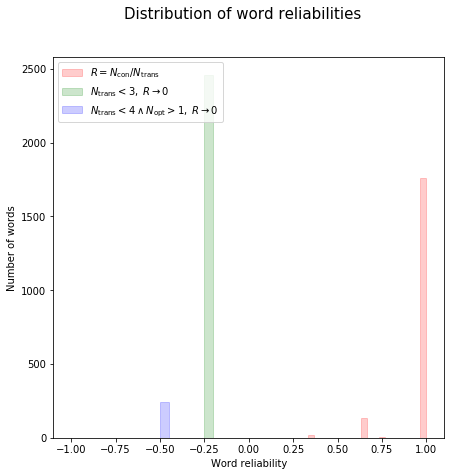

In [25]:
gc.collect()
allWordReliabilities = np.array(
    list(
        itertools.chain(* [
            wordData['wordReliabilities']
            for wordData in lineGroupedTranscriptionLineDetails["words"]
        ])))
mplplot.figure(figsize=(7, 7))
mplplot.suptitle('Distribution of word reliabilities', fontsize=15)
mplplot.xlabel('Word reliability')
mplplot.ylabel('Number of words')
allWordReliabilityAxis = mplplot.hist(
    allWordReliabilities[allWordReliabilities > 0],
    bins=20,
    histtype='step',
    alpha=0.2,
    fill=True,
    fc='r',
    ec='r',
    label=r"$R = N_{\rm con}/N_{\rm trans}$")
allWordReliabilityAxis = mplplot.hist(
    allWordReliabilities[np.logical_and(allWordReliabilities > -0.3,
                                        allWordReliabilities < 0.0)],
    bins=20,
    histtype='step',
    alpha=0.2,
    fill=True,
    fc='g',
    ec='g',
    label=r"$N_{\rm trans} < 3,\;R\rightarrow 0$")
allWordReliabilityAxis = mplplot.hist(
    allWordReliabilities[np.logical_and(allWordReliabilities > -0.6,
                                        allWordReliabilities < -0.3)],
    bins=20,
    histtype='step',
    alpha=0.2,
    fill=True,
    fc='b',
    ec='b',
    label=r"$N_{\rm trans} < 4 \wedge N_{\rm opt} > 1,\;R\rightarrow 0$")
handles, labels = mplplot.gcf().gca().get_legend_handles_labels()
mplplot.legend(handles[:], labels[:], loc='upper left')
mplplot.show()

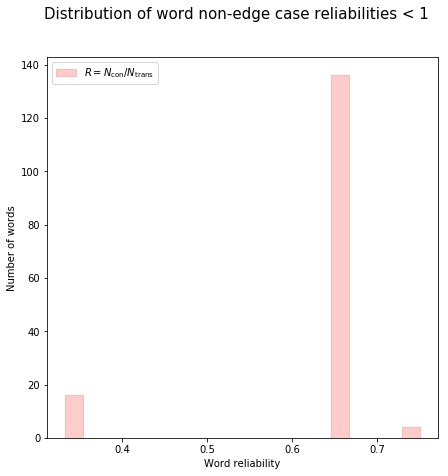

In [26]:
gc.collect()
allWordReliabilities = np.array(
    list(
        itertools.chain(* [
            wordData['wordReliabilities']
            for wordData in lineGroupedTranscriptionLineDetails["words"]
        ])))
mplplot.figure(figsize=(7, 7))
mplplot.suptitle(
    'Distribution of word non-edge case reliabilities < 1', fontsize=15)
mplplot.xlabel('Word reliability')
mplplot.ylabel('Number of words')
allWordReliabilityAxis = mplplot.hist(
    allWordReliabilities[np.logical_and(allWordReliabilities > 0,
                                        allWordReliabilities < 1)],
    bins=20,
    histtype='step',
    alpha=0.2,
    fill=True,
    fc='r',
    ec='r',
    label=r"$R = N_{\rm con}/N_{\rm trans}$")
handles, labels = mplplot.gcf().gca().get_legend_handles_labels()
mplplot.legend(handles[:], labels[:], loc='upper left')
mplplot.show()

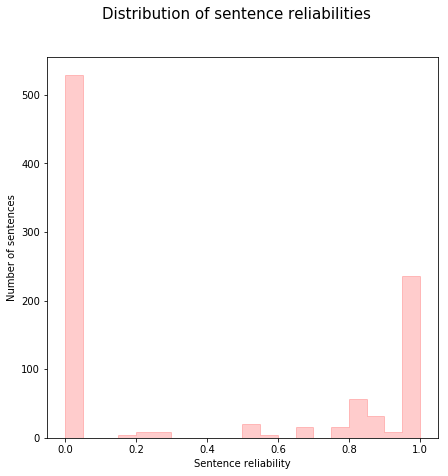

In [27]:
gc.collect()
allSentenceReliabilities = np.array([
    wordData['reliability']
    for wordData in lineGroupedTranscriptionLineDetails["words"]
])
mplplot.figure(figsize=(7, 7))
mplplot.suptitle('Distribution of sentence reliabilities', fontsize=15)
mplplot.xlabel('Sentence reliability')
mplplot.ylabel('Number of sentences')
allSentenceReliabilityAxis = mplplot.hist(
    allSentenceReliabilities,
    bins=20,
    histtype='step',
    alpha=0.2,
    fill=True,
    fc='r',
    ec='r')

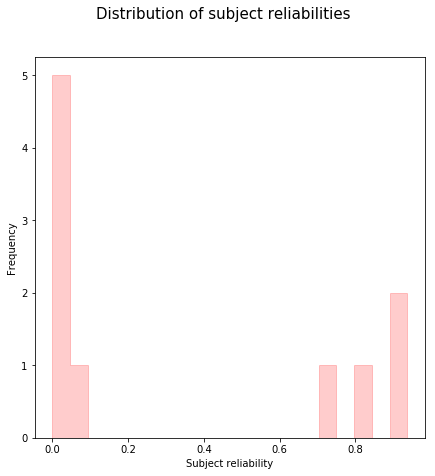

In [28]:
gc.collect()
subjectGroupedTranscriptionLineDetails = lineGroupedTranscriptionLineDetails.groupby(level=0).aggregate({'words' : lambda sentences : np.sum([sentence['reliability'] for sentence in sentences])/float(len(sentences))})
mplplot.figure(figsize=(7, 7))
mplplot.suptitle('Distribution of subject reliabilities', fontsize=15)
mplplot.xlabel('Subject reliability')
mplplot.ylabel('Number of subjects')
allSentenceReliabilityAxis = subjectGroupedTranscriptionLineDetails[
    'words'].plot.hist(
        bins=20, histtype='step', alpha=0.2, fill=True, fc='r', ec='r')

In [29]:
from IPython.display import Audio
Audio(
    filename=
    '/Users/hughdickinson/Downloads/jdk1.8.0_112/demo/applets/JumpingBox/sounds/danger.au',
    autoplay=True)

In [30]:
gc.collect()
retiredSubjectGroupedTranscriptionLineDetails = lineGroupedTranscriptionLineDetails[lineGroupedTranscriptionLineDetails['retired']].groupby(level=0).aggregate({'words' : lambda sentences : np.sum([sentence['reliability'] for sentence in sentences])/float(len(sentences))})
mplplot.figure(figsize=(7, 7))
mplplot.suptitle(
    'Distribution of subject reliabilities for retired subjects', fontsize=15)
mplplot.xlabel('Subject reliability')
mplplot.ylabel('Number of subjects')
allSentenceReliabilityAxis = retiredSubjectGroupedTranscriptionLineDetails[
    'words'].plot.hist(
        bins=20, histtype='step', alpha=0.2, fill=True, fc='r', ec='r')

KeyError: 'retired'

## Store consensus data in MySQL database

The consensus data for the telegrams are stored in a MySQL database that was created using the following commands:

```sql
CREATE DATABASE dcwConsensus;

USE dcwConsensus;

CREATE TABLE Subjects (
id INT AUTO_INCREMENT NOT NULL PRIMARY KEY,
zooniverseId INT NOT NULL,
huntingtonId CHAR(20) NOT NULL,
url VARCHAR(500) NOT NULL,
subjectReliability DECIMAL(5,4) NOT NULL DEFAULT 0.0
);

CREATE TABLE SubjectLines (
id INT AUTO_INCREMENT NOT NULL PRIMARY KEY,
subjectId INT NOT NULL,
bestLineIndex INT NOT NULL,
meanX1 DECIMAL(7,3) NOT NULL,
meanX2 DECIMAL(7,3) NOT NULL,
meanY1 DECIMAL(7,3) NOT NULL,
meanY2 DECIMAL(7,3) NOT NULL,
lineReliability DECIMAL(5,4) NOT NULL DEFAULT 0.0
);

CREATE TABLE LineWords (
id INT AUTO_INCREMENT NOT NULL PRIMARY KEY,
lineId INT NOT NULL,
wordText VARCHAR(100) CHARACTER SET utf16,
position INT NOT NULL,
rank INT NOT NULL,
transcriptionIndex INT NOT NULL,
spanStart INT NOT NULL,
spanEnd INT NOT NULL,
wordReliability DECIMAL(5,4) NOT NULL DEFAULT 0.0
);

CREATE TABLE MetaTags (
id INT AUTO_INCREMENT NOT NULL PRIMARY KEY,
bestLineIndex INT NOT NULL,
transcriptionIndex INT NOT NULL,
state ENUM('unclear', 'insertion', 'deletion') NOT NULL,
start INT NOT NULL,
end INT NOT NULL,
UNIQUE KEY(bestLineIndex, transcriptionIndex, state, start)
);
```